In [1]:
import sys
sys.path.append("..")
from utils.model_utils import *
import numpy as np

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
import os
import socket
import torch
import matplotlib.pyplot as plt
from verify_utils.verify_utils import get_params_list, get_lower_and_upper_bounds
from experiments.verify_gp import verify
from verify_utils.gp_verify_utils import verify_single_image_gp
def setup_gurobi():
    print('HOSTNAME: ', socket.gethostname())
    print(os.popen('hostid').read().strip())
    os.environ['GRB_LICENSE_FILE'] = '/nfs/homedirs/wangxun/gurobi_lic/{}.lic'.format(
        socket.gethostname())



In [3]:
setup_gurobi()

HOSTNAME:  gpu04
007f0101


In [4]:
import gurobipy as gp
from gurobipy import GRB

In [5]:
# model.AddVar
# addVar ( lb=0.0, ub=float('inf'), obj=0.0, vtype=GRB.CONTINUOUS, name="", column=None )
"""
x = model.addVar()                                     # all default arguments
y = model.addVar(vtype=GRB.INTEGER, obj=1.0, name="y") # arguments by name
z = model.addVar(0.0, 1.0, 1.0, GRB.BINARY, "z")       # arguments by position
"""
# model.AddVars
# addVars ( *indices, lb=0.0, ub=float('inf'), obj=0.0, vtype=GRB.CONTINUOUS, name="" )
"""
# 3-D array of binary variables
x = model.addVars(3, 4, 5, vtype=GRB.BINARY)

# variables index by tuplelist
l = tuplelist([(1, 2), (1, 3), (2, 3)])
y = model.addVars(l, ub=[1, 2, 3])
"""
# model.AddMvar() numpy ndarray of gurobi variables
"""
addMVar ( shape, lb=0.0, ub=float('inf'), obj=0.0, vtype=GRB.CONTINUOUS, name="" )
x = model.addMVar(10)                      # add a 1-D array of 10 variables
y = model.addMVar((3,4), vtype=GRB.BINARY) # add a 3x4 2-D array of binary variables
print(y[:,1:3])                            # take a slice of a 2-D array
"""

'\naddMVar ( shape, lb=0.0, ub=float(\'inf\'), obj=0.0, vtype=GRB.CONTINUOUS, name="" )\nx = model.addMVar(10)                      # add a 1-D array of 10 variables\ny = model.addMVar((3,4), vtype=GRB.BINARY) # add a 3x4 2-D array of binary variables\nprint(y[:,1:3])                            # take a slice of a 2-D array\n'

In [6]:
# model addConstr
"""
model.addConstr(x + y <= 2.0, "c1")
model.addConstr(x*x + y*y <= 4.0, "qc0")
model.addConstr(x + y + z == [1, 2], "rgc0")
model.addConstr(A @ t >= b)
model.addConstr(z == and_(x, y, w), "gc0")
model.addConstr(z == min_(x, y), "gc1")
model.addConstr((w == 1) >> (x + y <= 1), "ic0")
"""

# model addConstrs
"""
m.addConstrs((x[i] <= 1 for i in range(4)), name='c')
m.addConstrs((x[i,j] == 0 for i in range(4)
                            for j in range(4)
                            if i != j), name='c')
                            
model.addConstrs(x.sum(i, '*') <= capacity[i] for i in range(5))
model.addConstrs(x[i] + x[j] <= 1 for i in range(5) for j in range(5))
model.addConstrs(x[i]*x[i] + y[i]*y[i] <= 1 for i in range(5))
model.addConstrs(x.sum(i, '*') == [0, 2] for i in [1, 2, 4])
model.addConstrs(z[i] == max_(x[i], y[i]) for i in range(5))
model.addConstrs((x[i] == 1) >> (y[i] + z[i] <= 5) for i in range(5))
"""

# model.addLConstr()   add a linear constraints to a model
# addLConstr ( lhs, sense=None, rhs=None, name="" )
"""
model.addLConstr(x + 2*y, GRB.EQUAL, 3*z, "c0")
model.addLConstr(x + y <= 2.0, "c1")
model.addLConstr(LinExpr([1.0,1.0], [x,y]), GRB.LESS_EQUAL, 1)
"""

# model.addMConstr() add a set of linear constraints to the model
# addMConstr ( A, x, sense, b, name="" )
"""
A: constraint matrix, a numpy 2-D ndarray or a Scipy Sparse matrix
x: decision varibale
b: right-hand side vecotr
"""

'\nA: constraint matrix, a numpy 2-D ndarray or a Scipy Sparse matrix\nx: decision varibale\nb: right-hand side vecotr\n'

In [7]:
# model.setObjective()
# setObjective ( expr, sense=None )
"""
model.setObjective(x + y, GRB.MAXIMIZE)
model.setObjective(x*x + y*y)
"""

'\nmodel.setObjective(x + y, GRB.MAXIMIZE)\nmodel.setObjective(x*x + y*y)\n'

In [8]:
# Define a 2 layer model verifier 

In [9]:
# load model and dataset


In [13]:
arguments={}
arguments['data_set'] = "MNIST"
arguments['batch_size'] = 64
arguments['mean'] = (0.1307,)
arguments['std'] = (0.3081,)
arguments['tuning'] = 0
arguments['preload_all_data'] = 0
arguments['random_shuffle_labels'] = 0
train_loader, test_loader = find_right_model(
        DATASETS, arguments['data_set'],
        arguments=arguments,
        mean=arguments['mean'],
        std=arguments['std'])

Using mean (0.1307,)


In [14]:
checkpoint_name = "2022-05-20_16.19.39_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.75_train-scheme=DefaultTrainer_seed=1234"
checkpoint_model = "MLP2_mod_finished"
#checkpoint_name="2022-05-11_17.20.23_model=MLP3_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234"
#checkpoint_model = "MLP3_mod_finished"
#checkpoint_name = "2022-05-25_00.29.35_test_base_MLP5"
#checkpoint_model="MLP5_mod_loaded"

model_path = os.path.join(RESULTS_DIR,checkpoint_name,MODELS_DIR,checkpoint_model)

model=DATA_MANAGER.load_python_obj(model_path)
model

Loaded results/2022-05-20_16.19.39_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.75_train-scheme=DefaultTrainer_seed=1234/models/MLP2_mod_finished


MLP2(
  (layers): Sequential(
    (0): ContainerLinear(in_features=784, out_features=15.0, bias=True)
    (1): ReLU()
    (2): ContainerLinear(in_features=15.0, out_features=10, bias=True)
  )
)

In [15]:
device='cuda'


In [16]:
import torch
imgs,labels = next(iter(test_loader))
test_img=imgs[0].to(device)

pred=torch.argmax(model(test_img),axis=1).item()
num_classes = model.output_dim
other_classes = set(range(num_classes))
other_classes.remove(pred)

In [17]:
img = test_img.cpu().numpy().reshape(-1)
eps=0.001

In [18]:
W,b = get_params_list(model)
L,U = get_lower_and_upper_bounds(img,eps,W,b)


In [16]:
# define a 2 layer model verifier
m = gp.Model("verify")
m.Params.LogToConsole = 0
# add Variables
x_in = m.addMVar((784),lb=L[0],ub=U[0],name="input")
x_1 = m.addMVar((15),lb=L[1],ub=U[1],name="x_1")
y_1 = m.addMVar((15),name="y_1")
x_2 = m.addMVar(10,lb=-10,name="x_2")
m.addConstr(x_1==W[0]@x_in+b[0])
m.addConstr(x_2==W[1]@y_1+b[1])


Set parameter Username


2022-06-01 13:59:33 (INFO): Set parameter Username


Academic license - for non-commercial use only - expires 2023-05-22


2022-06-01 13:59:33 (INFO): Academic license - for non-commercial use only - expires 2023-05-22


<(10,) matrix constraint *awaiting model update*>

In [17]:
# add input perturbation budged

m.addConstrs((x_in[i]>=img[i]-eps for i in range(784)));
m.addConstrs((x_in[i]<=img[i]+eps for i in range(784)));

In [18]:
# add relu constraints
# y_1=relu(x_1)
a = m.addVars(15, vtype=GRB.BINARY,name="a")

m.addConstrs((y_1[i]<=x_1[i]-L[1][i]*(1-a[i]) for i in range(15)));
m.addConstrs((y_1[i]<=U[1][i]*a[i] for i in range(15)));
m.addConstrs((y_1[i]>=x_1[i] for i in range(15)));
m.addConstrs((y_1[i]>=0 for i in range(15)));

In [19]:
indicator=0
for other in other_classes:
    #m.setObjective(x_2[pred]-x_2[other], GRB.MINIMIZE)
    m.setObjective(x_2[pred])
    m.optimize()
    if m.ObjVal<0:
        indicator=1
        print("found solution")
        break
    

In [20]:
if indicator==0:
    print("verified")
else:
    print("found adversarial solution")

verified


In [21]:
m.ObjVal

12.071779956619793

In [22]:
#for v in m.getVars():
#    print('%s %g' % (v.VarName, v.X))

In [23]:
#checkpoint_name = "2022-05-20_16.19.39_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.75_train-scheme=DefaultTrainer_seed=1234"
#checkpoint_model = "MLP2_mod_finished"
checkpoint_name="2022-05-11_17.20.23_model=MLP3_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234"
checkpoint_model = "MLP3_mod_finished"
#checkpoint_name = "2022-05-25_00.29.35_test_base_MLP5"
#checkpoint_model="MLP5_mod_loaded"

model_path = os.path.join(RESULTS_DIR,checkpoint_name,MODELS_DIR,checkpoint_model)

model=DATA_MANAGER.load_python_obj(model_path)
model

Loaded results/2022-05-11_17.20.23_model=MLP3_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234/models/MLP3_mod_finished


MLP3(
  (layers): Sequential(
    (0): ContainerLinear(in_features=784, out_features=32.0, bias=True)
    (1): ReLU()
    (2): ContainerLinear(in_features=32.0, out_features=31.0, bias=True)
    (3): ReLU()
    (4): ContainerLinear(in_features=31.0, out_features=10, bias=True)
  )
)

In [24]:
test_img = imgs[0].to(device)
pred=torch.argmax(model(test_img),axis=1).item()
num_classes = model.output_dim
other_classes = set(range(num_classes))
other_classes.remove(pred)
img = imgs[0].cpu().numpy().reshape(-1)
eps=0.001
print("pred",pred)

pred 7


In [25]:
W,b = get_params_list(model)

L,U = get_lower_and_upper_bounds(img,eps,W,b)

In [26]:
W[0].shape,W[1].shape,W[2].shape,b[0].shape,b[1].shape,b[2].shape


((32, 784), (31, 32), (10, 31), (32,), (31,), (10,))

In [27]:

unstable_nums=[]
((L[1]<0) & (U[1]>0)).sum()
for l,u in zip(L,U):
    unstable_nums.append(int(((l<0) & (u>0)).sum()))
unstable_nums,unstable_nums[1]
print(unstable_nums)


[0, 0, 0, 2]


In [28]:
# define a 2 layer model verifier
m = gp.Model("verify")

# add Variables
x_in = m.addMVar((784),lb=-GRB.INFINITY,name="input")
x_1 = m.addMVar((32),lb=-GRB.INFINITY,name="x_1")
y_1 = m.addMVar((32),lb=-GRB.INFINITY,name="y_1")
x_2 = m.addMVar((31),lb=-GRB.INFINITY,name="x_2")
y_2 = m.addMVar((31),lb=-GRB.INFINITY,name="y_2")
x_3 = m.addMVar((10),lb=-GRB.INFINITY,name="x_3")

m.addConstr(W[0]@x_in+b[0]==x_1)
m.addConstr(W[1]@y_1+b[1]==x_2)
m.addConstr(W[2]@y_2+b[2]==x_3)

# add relu constraints
# y_1=relu(x_1)
a1 = m.addVars(unstable_nums[1], vtype=GRB.BINARY,name="a1")
j=0
for i in range(32):
    if L[1][i]>=0:
        m.addConstr(y_1[i]==x_1[i]);
    elif U[1][i]<=0:
        m.addConstr(y_1[i]==0);
    else:
        m.addConstr(y_1[i]<=x_1[i]-L[1][i]*(1-a1[j])) ;
        m.addConstr(y_1[i]<=U[1][i]*a1[j]);
        m.addConstr(y_1[i]>=x_1[i]);
        m.addConstr(y_1[i]>=0);
        j+=1

# add relu constraints
# y_2=relu(x_2)
a2 = m.addVars(unstable_nums[2], vtype=GRB.BINARY,name="a2")
j=0
for i in range(31):
    if L[2][i]>=0:
        m.addConstr(y_2[i]==x_2[i]);
    elif U[2][i]<=0:
        m.addConstr(y_2[i]==0);
    else:
        m.addConstr(y_2[i]<=x_2[i]-L[2][i]*(1-a2[j])) ;
        m.addConstr(y_2[i]<=U[2][i]*a2[j]);
        m.addConstr(y_2[i]>=x_2[i]);
        m.addConstr(y_2[i]>=0);
        j+=1

# add input perturbation budged

m.addConstrs((x_in[i]>=img[i]-eps for i in range(784)));
m.addConstrs((x_in[i]<=img[i]+eps for i in range(784)));

In [29]:
#m.Params.Cuts=0
#m.Params.GomoryPasses=0
#m.Params.ScaleFlag=2


In [30]:
#m.setObjective(x_3[pred]-x_3[other], GRB.MINIMIZE)
#iis=m.computeIIS()
#m.write("model.ilp")

In [31]:
indicator=0
m.Params.LogToConsole = 0
for other in other_classes:
    m.setObjective(x_3[pred]-x_3[other], GRB.MINIMIZE)
    #m.setObjective(x_in[0], GRB.MINIMIZE)
    m.optimize()
    if m.ObjVal<0:
        indicator=1
        print("found solution")
        print(m.ObjVal)
        break
    

In [32]:

m.status

2

In [33]:

x_input=[]
y_output=[]
for v in m.getVars():
    if "input" in v.VarName:
        x_input.append(v.X)
    if "x_3" in v.VarName:
        y_output.append(v.X)
    #print('%s %g' % (v.VarName, v.X))


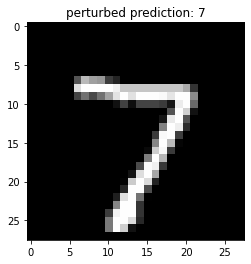

In [34]:
x_input=np.array(x_input).reshape(28,28)
label=np.argmax(y_output)

plt.imshow(x_input, cmap='gray')
plt.title(f"perturbed prediction: {label}")
plt.show()


# Sanity check

In [35]:
x_input=[]
x_1=[]
y_1=[]
x_2=[]
y_2=[]
x_3=[]
for v in m.getVars():
    if "input" in v.VarName:
        x_input.append(v.X)
    if "x_1" in v.VarName:
        x_1.append(v.X)
    if "y_1" in v.VarName:
        y_1.append(v.X)
    if "x_2" in v.VarName:
        x_2.append(v.X)
    if "y_2" in v.VarName:
        y_2.append(v.X)
    if "x_3" in v.VarName:
        x_3.append(v.X)        
        
x_input=np.array(x_input)
x_1 = np.array(x_1)
y_1 = np.array(y_1)
x_2 = np.array(x_2)
y_2 = np.array(y_2)
x_3= np.array(x_3)


x_1_ = W[0]@x_input+b[0]
x_2_ = W[1]@y_1+b[1]
x_3_ = W[2]@y_2+b[2]
print(np.isclose(x_1_,x_1,atol=1e-8))
print(np.isclose(x_2_,x_2,atol=1e-8))
print(np.isclose(x_3_,x_3,atol=1e-8))

print(np.isclose((x_1>0)*x_1,y_1,atol=1e-8))
print(np.isclose((x_2>0)*x_2,y_2,atol=1e-8))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]


# verification for N layer network

In [19]:
#checkpoint_name = "2022-05-20_16.19.39_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.75_train-scheme=DefaultTrainer_seed=1234"
#checkpoint_model = "MLP2_mod_finished"
#checkpoint_name="2022-05-11_17.20.23_model=MLP3_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234"
#checkpoint_model = "MLP3_mod_finished"
checkpoint_name = "2022-05-25_00.29.35_test_base_MLP5"
checkpoint_model="MLP5_mod_loaded"

model_path = os.path.join(RESULTS_DIR,checkpoint_name,MODELS_DIR,checkpoint_model)

model=DATA_MANAGER.load_python_obj(model_path)
model.to(device)

Loaded results/2022-05-25_00.29.35_test_base_MLP5/models/MLP5_mod_loaded


MLP5(
  (layers): Sequential(
    (0): ContainerLinear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): ContainerLinear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): ContainerLinear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): ContainerLinear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): ContainerLinear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): ContainerLinear(in_features=100, out_features=10, bias=True)
  )
)

In [20]:
model.to('cpu')
correct=0
total=0
for imgs, labels in test_loader:
    correct+=torch.sum(torch.argmax(model(imgs),axis=1)==labels).item()
    total+=len(labels)
accuracy=correct/total
print(f"acc:{accuracy}")

acc:0.9794


In [59]:
test_img = imgs[0]
pred=torch.argmax(model(test_img),axis=1).item()
num_classes = model.output_dim
other_classes = set(range(num_classes))
other_classes.remove(pred)
img = test_img.cpu().numpy().reshape(-1)
eps=0.02

print("pred",pred)

pred 1


In [60]:
W,b = get_params_list(model)
L,U = get_lower_and_upper_bounds(img,eps,W,b)


In [61]:
num_layers = len(W)
print("num_layers",num_layers)
shapes=[]
for i in range(num_layers):
        shapes.append(U[i].shape[0])
shapes.append(num_classes)
shapes

num_layers 6


[784, 100, 100, 100, 100, 100, 10]

In [62]:
unstable_nums=[]
# don't use the first layer and final layer
for l,u in zip(L[1:-1],U[1:-1]):
    unstable_nums.append(int(((l<=0) & (u>=0)).sum()))
unstable_nums

[4, 15, 53, 94, 99]

In [63]:
L[-1],U[-1]

(array([ -83.770424,  -69.926636,  -84.54936 , -101.2452  ,  -84.26327 ,
         -68.401886,  -99.76051 ,  -87.23797 , -113.073204,  -47.31114 ],
       dtype=float32),
 array([ 94.788216, 105.446205, 113.78178 , 112.83693 , 100.999695,
        101.54098 , 100.38173 , 117.08383 , 120.006195,  77.80508 ],
       dtype=float32))

In [64]:
m = gp.Model("verify-n-layer")
X=[]
Y=[]
A=[]
# X[0] is input X[-1] is output
# setting the lower and upper bounds for the inputs already take perturbation budget into account
# Y is output after relu
# A is binary variable for relu constraints
for i in range(num_layers+1):
    X.append(m.addMVar((shapes[i]),lb=L[i],ub=U[i],name=f"x_{i}"))
for i in range(num_layers-1):
    Y.append(m.addMVar(shapes[i+1],name=f"y_{i}"))
    A.append(m.addVars(shapes[i+1], vtype=GRB.BINARY,name=f"a_{i}"))
#for i,num in enumerate(unstable_nums):
#    A.append(m.addVars(num, vtype=GRB.BINARY,name=f"a_{i}"))

# define constraints
# input perturbation
#m.addConstrs((X[0][i]>=img[i]-eps for i in range(shapes[0])));
#m.addConstrs((X[0][i]<=img[i]+eps for i in range(shapes[0])));
# Linear 
# X1 = W0 @ X0 + b0
# X2 = W1 @ Y0 + b1
# X3 = W2 @ Y1 + b2
# ...
for i in range(num_layers):
    if i==0:
        m.addConstr(W[0]@X[0]+b[0]==X[1]);
    else:
        m.addConstr(W[i]@Y[i-1]+b[i]==X[i+1]);
        
    # relu 
    # Y0 = relu(X1)
    # Y1 = relu(X2)
    # ...
for i in range(num_layers-1):
    m.addConstrs((Y[i][j]<=X[i+1][j]-L[i+1][j]*(1-A[i][j]) for j in range(shapes[i+1])));
    m.addConstrs((Y[i][j]<=U[i+1][j]*A[i][j] for j in range(shapes[i+1])));
    m.addConstrs((Y[i][j]>=X[i+1][j] for j in range(shapes[i+1])));
    m.addConstrs((Y[i][j]>=0 for j in range(shapes[i+1])));
"""
relu 
    if stable(l>0 y0=x1, u<0, y0=1)
    if unstable (y0=relu(x1))
        
# Y0 = relu(X1)
# Y1 = relu(X2)
# ...


for i in range(num_layers-1):
    k=0
    for j in range(shapes[i+1]):
        if L[i+1][j]>=0:
            m.addConstr(Y[i][j]==X[i+1][j]);
        elif U[i+1][j]<=0:
            m.addConstr(Y[i][j]==0);
        else:
            m.addConstr(Y[i][j]<=X[i+1][j]-L[i+1][j]*(1-A[i][k])) ;
            m.addConstr(Y[i][j]<=U[i+1][i]*A[i][k]);
            m.addConstr(Y[i][j]>=X[i+1][j]);
            m.addConstr(Y[i][j]>=0);
            k+=1
    print(k)

"""

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 14:50:00 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


'\nrelu \n    if stable(l>0 y0=x1, u<0, y0=1)\n    if unstable (y0=relu(x1))\n        \n# Y0 = relu(X1)\n# Y1 = relu(X2)\n# ...\n\n\nfor i in range(num_layers-1):\n    k=0\n    for j in range(shapes[i+1]):\n        if L[i+1][j]>=0:\n            m.addConstr(Y[i][j]==X[i+1][j]);\n        elif U[i+1][j]<=0:\n            m.addConstr(Y[i][j]==0);\n        else:\n            m.addConstr(Y[i][j]<=X[i+1][j]-L[i+1][j]*(1-A[i][k])) ;\n            m.addConstr(Y[i][j]<=U[i+1][i]*A[i][k]);\n            m.addConstr(Y[i][j]>=X[i+1][j]);\n            m.addConstr(Y[i][j]>=0);\n            k+=1\n    print(k)\n\n'

In [65]:
#iis=m.computeIIS()
#m.write("model.ilp")

In [66]:
"""
for i in range(shapes[0]):
    X[0][i].Start = img[i]
X1_=W[0]@img+b[0]
for i in range(shapes[1]):
    X[1][i].Start = X1_[i]
Y0_ = (X1_>0)*X1_
for i in range(shapes[1]):
    Y[0][i].Start = Y0_[i]

"""


'\nfor i in range(shapes[0]):\n    X[0][i].Start = img[i]\nX1_=W[0]@img+b[0]\nfor i in range(shapes[1]):\n    X[1][i].Start = X1_[i]\nY0_ = (X1_>0)*X1_\nfor i in range(shapes[1]):\n    Y[0][i].Start = Y0_[i]\n\n'

In [70]:
import time
start=time.time()
verified=1
infeasible = 0
m.Params.LogToConsole = 0
for other in other_classes:
    print(f"verifing: {other}")
    m.setObjective(X[-1][pred]-X[-1][other], GRB.MINIMIZE)
    m.optimize()
    try:
        if m.ObjVal<0:
            verified=0
            infeasible=0
            print("found solution")
            break
    except AttributeError:
        print("inf")
        infeasible=1
        continue
if infeasible ==1:
    verified=0
    print("infeasible")
if verified==1:
    print("verified")
end=time.time()
print(f"spent {end-start}s")

verifing: 0
verifing: 2
verifing: 3
verifing: 4
verifing: 5
verifing: 6
verifing: 7
verifing: 8
verifing: 9
verified
spent 135.01071953773499s


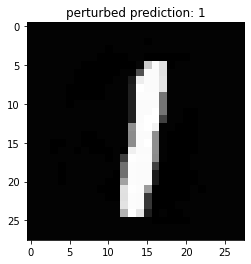

In [71]:
x_input=[]
y_output=[]
for v in m.getVars():
    if "x_0" in v.VarName:
        x_input.append(v.X)
    if "x_6" in v.VarName:
        y_output.append(v.X)
    #print('%s %g' % (v.VarName, v.X))
x_input=np.array(x_input).reshape(28,28)
label=np.argmax(y_output)
plt.imshow(x_input, cmap='gray')
plt.title(f"perturbed prediction: {label}")
plt.show()

In [52]:
x_0=[]
x_1=[]
y_0=[]
x_2=[]
y_1=[]
x_3=[]
y_2=[]
x_4=[]
y_3=[]
x_5=[]
y_4=[]
x_6=[]
for v in m.getVars():
    if "x_0" in v.VarName:
        x_0.append(v.X)
    if "x_1" in v.VarName:
        x_1.append(v.X)
    if "y_0" in v.VarName:
        y_0.append(v.X)
    if "x_2" in v.VarName:
        x_2.append(v.X)
    if "y_1" in v.VarName:
        y_1.append(v.X)
    if "x_3" in v.VarName:
        x_3.append(v.X)  
    if "y_2" in v.VarName:
        y_2.append(v.X)
    if "x_4" in v.VarName:
        x_4.append(v.X)   
    if "y_3" in v.VarName:
        y_3.append(v.X)
    if "x_5" in v.VarName:
        x_5.append(v.X)  
    if "y_4" in v.VarName:
        y_4.append(v.X)
    if "x_6" in v.VarName:
        x_6.append(v.X)  
        
x_0=np.array(x_0)
x_1 = np.array(x_1)
y_0 = np.array(y_0)
x_2 = np.array(x_2)
y_1 = np.array(y_1)
x_3= np.array(x_3)



x_1_ = W[0]@x_0+b[0]
x_2_ = W[1]@y_0+b[1]
x_3_ = W[2]@y_1+b[2]
#print(np.isclose(x_1_,x_1,atol=1e-8))
#print(np.isclose(x_2_,x_2,atol=1e-8))
#print(np.isclose(x_3_,x_3,atol=1e-8))

print(np.isclose((x_1>0)*x_1,y_0,atol=1e-8))
print(np.isclose((x_2>0)*x_2,y_1,atol=1e-8))

#x_1[50],y_0[50],L[1][50],U[1][50]

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]


In [42]:
imgs,labels=next(iter(test_loader))
img=imgs[0]
eps=0.01
verified,infeasible=verify_single_image_gp(model,img,eps)
print(verified,infeasible)

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 17:24:00 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


1 0


In [ ]:
arguments={}
arguments['device']="cpu"

#arguments['checkpoint_name'] = "2022-05-20_16.19.39_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.75_train-scheme=DefaultTrainer_seed=1234"
#arguments['checkpoint_model'] = "MLP2_mod_finished"
#arguments['checkpoint_name']="2022-05-11_17.20.23_model=MLP3_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234"
#arguments['checkpoint_model'] = "MLP3_mod_finished"
arguments['checkpoint_name'] = "2022-05-25_00.29.35_test_base_MLP5"
arguments['checkpoint_model']="MLP5_mod_loaded"
arguments['seed']=1234
arguments['eps']=0.01

arguments['data_set'] = "MNIST"
arguments['batch_size'] = 32
arguments['mean'] = (0.1307,)
arguments['std'] = (0.3081,)
arguments['tuning'] = 0
arguments['preload_all_data'] = 0
arguments['random_shuffle_labels'] = 0
results1=verify(arguments)
arguments['eps']=0.03
results2=verify(arguments)


Loaded results/2022-05-25_00.29.35_test_base_MLP5/models/MLP5_mod_loaded
Using mean (0.1307,)
model accuracy: 0.9794
verify 1st batch data
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 17:27:17 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 17:29:45 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 17:30:38 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 17:33:45 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 17:35:23 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 17:37:25 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 17:39:24 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 17:42:14 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 17:43:46 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 17:44:34 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 17:45:45 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 17:50:07 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 17:53:20 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 17:54:42 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 17:57:46 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:01:22 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:03:13 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:04:32 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:07:12 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:10:04 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:13:05 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:15:42 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:19:34 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:21:30 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:23:27 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:25:32 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:28:22 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:35:24 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:36:57 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:38:17 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:41:56 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


2022-06-01 18:42:59 (INFO): Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


In [ ]:
results1,results2

In [ ]:
"""
Results

MLP2:[784, 32,  10] acc 94.51%

eps=0.01
{'accuracy': 0.9451,
  'data_num': 32,
  'verified_num': 10,
  'infeasible_num': 22,
  'time_per_img': 0.1279579997062683}

eps=0.03
{'accuracy': 0.9451,
  'data_num': 32,
  'verified_num': 13,
  'infeasible_num': 19,
  'time_per_img': 0.2503535747528076}

eps=0.1
{'accuracy': 0.9451,
  'data_num': 32,
  'verified_num': 12,
  'infeasible_num': 10,
  'time_per_img': 0.6505700498819351}
  
eps=0.3
{'accuracy': 0.9451,
  'data_num': 32,
  'verified_num': 0,
  'infeasible_num': 2,
  'time_per_img': 0.40503598004579544}
  
  
  
MLP3: [784, 32, 31, 10] acc: 96.94%

eps=0.01
{'accuracy': 0.9694,
  'data_num': 32,
  'verified_num': 1,
  'infeasible_num': 31,
  'time_per_img': 0.20245391130447388}
  
eps=0.03
{'accuracy': 0.9694,
  'data_num': 32,
  'verified_num': 3,
  'infeasible_num': 29,
  'time_per_img': 1.5850246921181679}

eps=0.1

{'accuracy': 0.9694,
 'data_num': 32,
 'verified_num': 5,
 'infeasible_num': 20,
 'time_per_img': 29.422851890325546}

{'accuracy': 0.9694,
 'data_num': 32,
 'verified_num': 0,
 'infeasible_num': 3,
 'time_per_img': 61.72579529136419}


MLP5:[784,100,100,100,100 10] acc 97.94%

eps=0.01
{'accuracy': 0.9794,
  'data_num': 32,
  'verified_num': 0,
  'infeasible_num': 32,
  'time_per_img': 0.30446118861436844}
  
eps=0.03
{'accuracy': 0.9794,
  'data_num': 32,
  'verified_num': 0,
  'infeasible_num': 32,
  'time_per_img': 1.490784928202629}

In [114]:
5/12

0.4166666666666667